(assign7_solution)=
# Assign7 Classification problem -- solution

- Make a jupyter notebook that reproduces the false color examples
  in{ref}`week10:false_color_examples` for your scene (you'll need to rerun  {ref}`week4:clip_bands` version 3 to get the clipped fmask, and rerun {ref}`week2:hls` to download all of the HLS tifs for bands 1,2,3,4,5,6,7,9,10,11,fmask if you don't have them).
- Choose one band combination that looks interesting, and compare it with the land classification you created using {ref}`week9:land_classes` for your image with the same bounding box and pixel size -- comment on any similarities and differences you can find.  Is the classification accurate?

In [1]:
import xarray
import rioxarray
from matplotlib import pyplot as plt
import numpy as np
from skimage import exposure, img_as_ubyte
from IPython.display import Image
from pathlib import Path
from numpy.typing import NDArray
from rasterio.enums import Resampling
import seaborn as sns

## False color bands for Vancouver

In [2]:
bands={'B01':'Coastal_Aerosol',
        'B02':'Blue',
        'B03':'Green',
        'B04':'Red',
        'B05':'NIR',
        'B06':'SWIR1',
        'B07':'SWIR2',
        'B09':'Cirrus',
        'B10':'TIRS1',
        'B11':'TIRS2',
        'fmask':'fmask'}

### Read all bands into a dictionary

Use the `bands` dictionary to identify the band by its name (Blue, Green, etc)
and store it in `scene_dict`.  Masking fmask would convert it from 8 bit to float, so we
need to special-case the fmask file.

In [3]:
data_dir = Path().home() / 'repos/a301/satdata/landsat'
all_tifs = list(data_dir.glob('**/week10*clipped_*.tif'))
scene_dict = {}
for key,bandname in bands.items():
    band_tif = None
    for the_tif in all_tifs:
        if str(the_tif).find(bandname) > -1:
            print(f"reading {key}:{the_tif}")
            if key == 'fmask':
                scene_dict[key] = rioxarray.open_rasterio(the_tif)
            else:
                scene_dict[key] = rioxarray.open_rasterio(the_tif, mask_and_scale=True)
            continue
   
    

reading B01:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Coastal_Aerosol.tif
reading B02:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Blue.tif
reading B03:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Green.tif
reading B04:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Red.tif
reading B05:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_NIR.tif
reading B06:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_SWIR1.tif
reading B07:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_SWIR2.tif
reading B09:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Cirrus.tif
reading B10:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_TIRS1.tif
reading B11:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_TIRS2.tif
reading fmask:

### Create an xarray dataset from the band dictionary

(make_dataset2)=
#### make_dataset function

In [4]:
from a301_extras.sat_lib import (make_dataset,
                                 make_bool_mask,
                                 make_false_color)
ds_allbands = make_dataset(scene_dict)

running __init__.py


In [5]:
ds_allbands

<xarray.Dataset> Size: 10MB
Dimensions:      (band: 1, x: 400, y: 600)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB 4.761e+05 4.761e+05 ... 4.881e+05 4.881e+05
  * y            (y) float64 5kB 5.465e+06 5.465e+06 ... 5.448e+06 5.447e+06
    spatial_ref  int64 8B 0
Data variables:
    B01          (band, y, x) float32 960kB ...
    B02          (band, y, x) float32 960kB ...
    B03          (band, y, x) float32 960kB ...
    B04          (band, y, x) float32 960kB ...
    B05          (band, y, x) float32 960kB ...
    B06          (band, y, x) float32 960kB ...
    B07          (band, y, x) float32 960kB ...
    B09          (band, y, x) float32 960kB ...
    B10          (band, y, x) float32 960kB ...
    B11          (band, y, x) float32 960kB ...
    fmask        (band, y, x) uint8 240kB ...
Attributes: (12/34)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       476100.0
    ULY:                       5465460.0
    USGS_SOFTWARE:             LPGS_16.3.0
    AREA_OR_POINT:             Area

### Make the mask

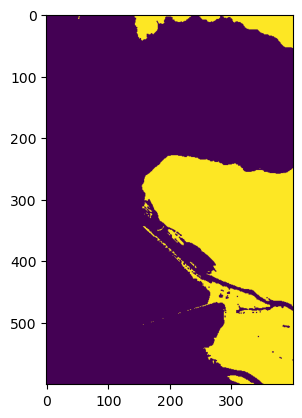

In [6]:
bool_image = make_bool_mask(scene_dict['fmask'])
plt.imshow(bool_image.squeeze())

## Urban swir-2, swir-1, red

concrete and bare soil have approximately constant reflectivities between 1.6 and 2.2 microns,
while vegetation reflects more in swir-1 than swir-2.  This combination distinguishes between
types of urban development.  Less contrast for turbid/fresh water.  See: [band764 detail](https://eos.com/make-an-analysis/shortwave-infrared/)

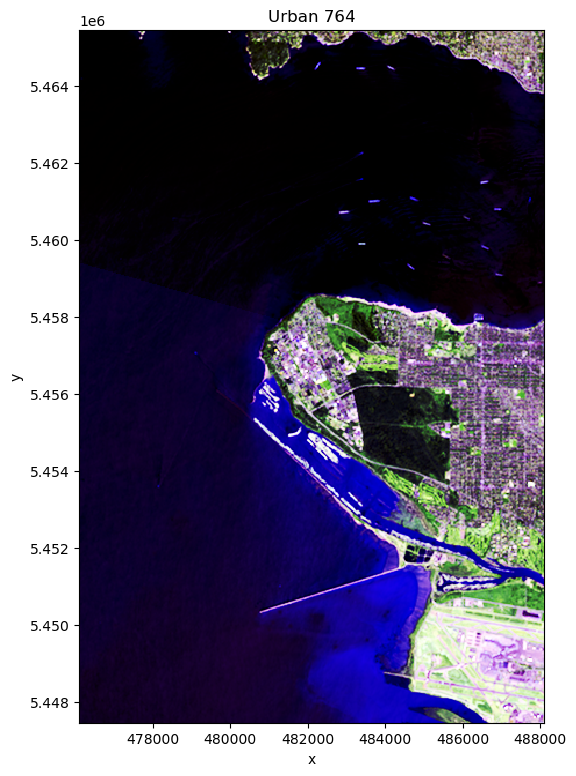

In [7]:
urban = make_false_color(ds_allbands, band_names=["B07","B06","B04"])
fig5, ax5 = plt.subplots(1,1,figsize=(6,9))
urban.plot.imshow(ax=ax5);
ax5.set(title="Urban 764");

## Read in the classification and resample

The land use/land classification process assigns a category between 0-11 for the following 9 categories
(they have combined former categories 3 and 6 in the the category 11 (rangeland).

$$
\begin{array}{|ll|}
\hline 0 & \text { No data } \\
\hline 1 & \text { Water } \\
\hline 2 & \text { Trees } \\
\hline 4 & \text { Flooded Vegetation }  \\
\hline 5 & \text { Crops }  \\
\hline 7 & \text { Built Area }  \\
\hline 8 & \text { Bare Ground }  \\
\hline 9 & \text { Snow/lce } \\
\hline 10 & \text { Clouds }  \\
\hline 11 & \text { Rangeland }  \\
\hline
\end{array}
$$

### get the bounds from band7

In [8]:
the_tif = list(data_dir.glob('**/vancouver_2023/10U*2023*tif'))[0]
print(the_tif)

/Users/phil/repos/a301/satdata/landsat/vancouver_2023/10U_2023.tif


### get the classification file

In [9]:
band7 = ds_allbands['B07'].squeeze()
bounds = band7.rio.bounds()
land_class = rioxarray.open_rasterio(the_tif)
land_class = land_class.squeeze()

## resample to band 7 grid

In [10]:
matched_class = land_class.rio.reproject_match(band7,
                                                  resampling=Resampling.mode)

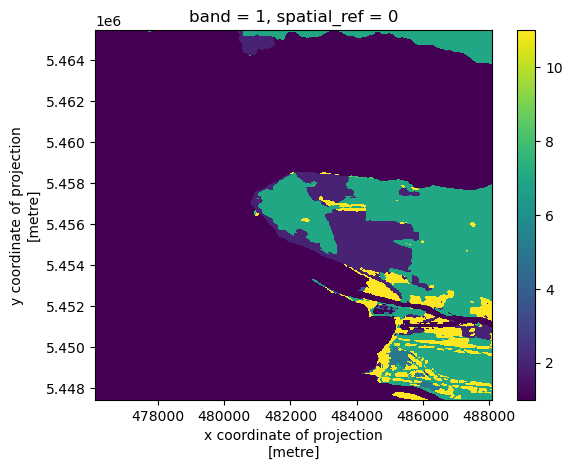

In [11]:
matched_class.plot.imshow();

(array([1.82188e+05, 1.23770e+04, 0.00000e+00, 1.66000e+02, 9.64000e+02,
        0.00000e+00, 3.63020e+04, 1.31000e+02, 0.00000e+00, 7.87200e+03]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

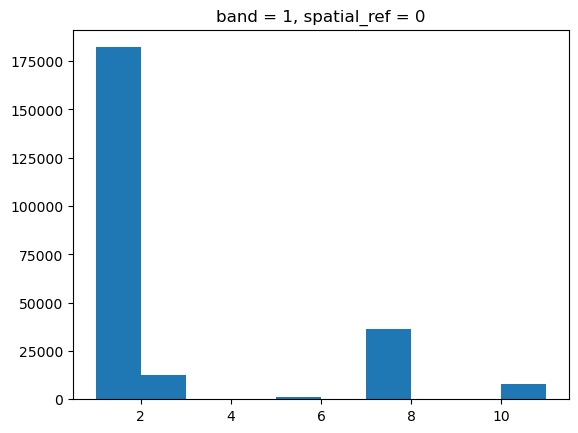

In [12]:
matched_class.plot.hist()

## Discussion

The classifier appeaars to be doing a good job of distinguishing the concrete runways as built, and the
mowed grass around the runways as rangeland. for the YVR runways. It also picks out the UBC golf course as
rangeland, but seems to also classify some sandy areas as rangeland around Iona spit. Not sure what's going
on with the crop classification in Point Grey. Would need to look at
[sentinel msi bands](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-spectral-bands) which are used to develop the classifier to see if they
are making some other kind of distinction in their bands 5-7 which landsat doesn't have

In [13]:
hit_built = matched_class.data == 7
hit_range = matched_class.data ==11
band6 = ds_allbands['B06'].squeeze()
band4 = ds_allbands['B04'].squeeze()

In [14]:
band7.shape

(600, 400)

In [15]:
band7_built = band7.data[hit_built]
band6_built = band6.data[hit_built]
band4_built = band4.data[hit_built]
band7_range = band7.data[hit_range]
band6_range = band6.data[hit_range]
band4_range = band4.data[hit_range]

### Jointplot for built pixels bands 6,7

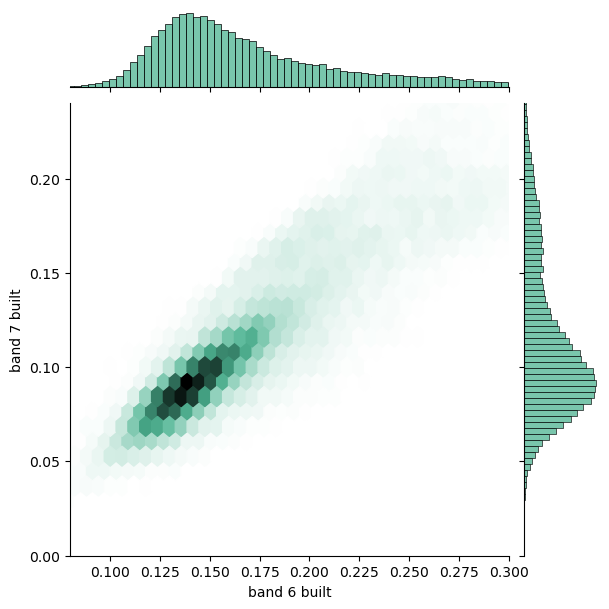

In [16]:
fig = sns.jointplot(
    x=band6_built,
    y=band7_built,
    kind="hex",
    xlim=(0.08, 0.3),
    ylim=(0.0, 0.24),
    color="#4CB391",
    gridsize=100,
)
fig.set_axis_labels("band 6 built", "band 7 built");

### Joint plot for range pixels, bands 6 and 7

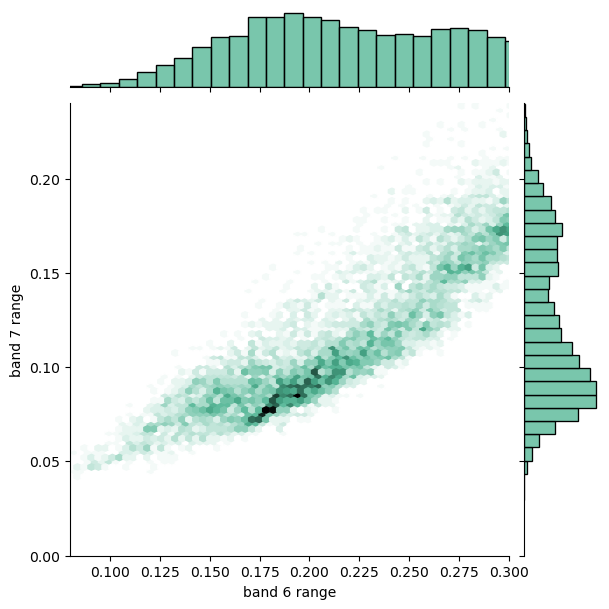

In [17]:
fig = sns.jointplot(
    x=band6_range,
    y=band7_range,
    kind="hex",
    xlim=(0.08, 0.3),
    ylim=(0.0, 0.24),
    color="#4CB391",
    gridsize=100,
)
fig.set_axis_labels("band 6 range", "band 7 range");

### Jointplot for built pixels bands 4,7

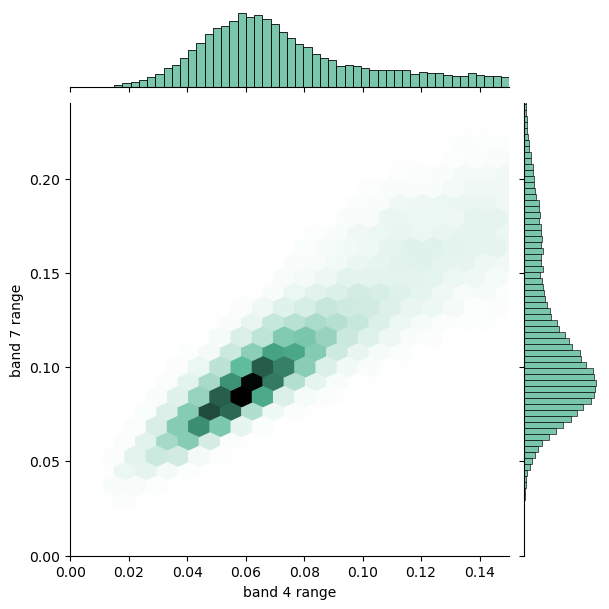

In [18]:
fig = sns.jointplot(
    x=band4_built,
    y=band7_built,
    kind="hex",
    xlim=(0.0, 0.15),
    ylim=(0.0, 0.24),
    color="#4CB391",
    gridsize=100,
)
fig.set_axis_labels("band 4 range", "band 7 range");

### Joint plot for range pixels bands 4, 7

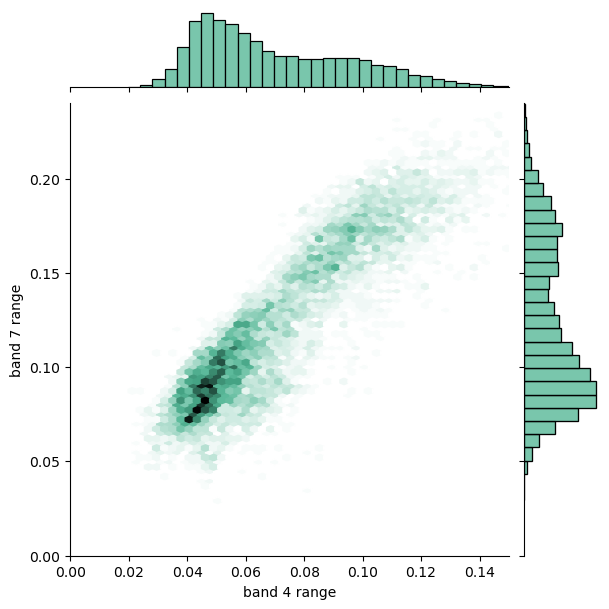

In [19]:
fig = sns.jointplot(
    x=band4_range,
    y=band7_range,
    kind="hex",
    xlim=(0.0, 0.15),
    ylim=(0.0, 0.24),
    color="#4CB391",
    gridsize=100,
)
fig.set_axis_labels("band 4 range", "band 7 range");